# Part 2 of 2 (OPTIONAL): An extreme case of regular expression processing

> This part is **OPTIONAL**. That is, while there are exercises, they are worth 0 points each. Rather, this notebook is designed for those of you who may have a deeper interest in computational aspects of the course material and would like to explore that.

There is a beautiful theory underlying regular expressions, and efficient regular expression processing is regarded as one of the classic problems of computer science. In the last part of this lab, you will explore a bit of that theory, albeit by experiment.

In particular, the code cells below will walk you through a simple example of the potentially **hidden cost** of regular expression parsing. And if you really want to geek out, look at the article on which this example is taken: https://swtch.com/~rsc/regexp/regexp1.html

## Quick review

**Exercise 0** (ungraded) Let $a^n$ be a shorthand notation for a string in which $a$ is repeated $n$ times. For example, $a^3$ is the same as $aaa$ and $a^6$ is the same as $aaaaaa$. Write a function to generate the string for $a^n$, given a string $a$ and an integer $n \geq 1$.

In [1]:
def rep_str (a, n):
    """Returns a string consisting of an input string repeated a given number of times."""
    assert type(a) is str and n >= 1
    #
    # YOUR CODE HERE
    #
    return a*n

In [2]:
# Test cell: `rep_str_test`

def check_fixed(a, n, ans):
    msg = "Testing: '{}'^{} -> '{}'".format(a, n, ans)
    print(msg)
    assert rep_str(a, n) == ans, "Case failed!"
    
check_fixed('a', 3, 'aaa')
check_fixed('cat', 4, 'catcatcatcat')
check_fixed('', 100, '')

def check_rand():
    from random import choice, randint
    a = ''.join([choice([chr(k) for k in range(ord('a'), ord('z')+1)]) for _ in range(randint(1, 5))])
    n = randint(1, 10)
    msg = "Testing: '{}'^{}".format(a, n)
    print(msg)
    s_you = rep_str(a, n)
    for k in range(0, n*len(a), len(a)):
        assert s_you[k:(k+len(a))] == a, "Your result, '{}', is not correct at position {} [{}].".format(s_you, k)
    
for _ in range(10):
    check_rand()

print("\n(Passed!)")

Testing: 'a'^3 -> 'aaa'
Testing: 'cat'^4 -> 'catcatcatcat'
Testing: ''^100 -> ''
Testing: 'yxno'^7
Testing: 'e'^4
Testing: 'ekheh'^5
Testing: 'pahkz'^6
Testing: 'pb'^3
Testing: 'ofv'^10
Testing: 'ven'^7
Testing: 'blhv'^6
Testing: 'kmkg'^9
Testing: 'ncpuk'^7

(Passed!)


## An initial experiment

Intuitively, you should expect (or hope) that the time to determine whether a string of length $n$ matches a given pattern will be proportional to $n$. Let's see if this holds when matching simple input strings of repeated letters against a pattern designed to match such strings.

In [3]:
import re

In [4]:
# Set up an input problem
n = 3
s_n = rep_str ('a', n) # Input string
pattern = '^a{%d}$' % n # Pattern to match it exactly

# Test it
print ("Matching input '{}' against pattern '{}'...".format (s_n, pattern))
assert re.match (pattern, s_n) is not None

# Benchmark it & report time, normalized to 'n'
timing = %timeit -q -o re.match (pattern, s_n)
t_avg = sum (timing.all_runs) / len (timing.all_runs) / timing.loops / n * 1e9
print ("Average time per match per `n`: {:.1f} ns".format (t_avg))

Matching input 'aaa' against pattern '^a{3}$'...
Average time per match per `n`: 304.6 ns


Before moving on, be sure you understand what the above benchmark is doing. For more on the Jupyter "magic" command, `%timeit`, see: http://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=magic#magic-magic

**Exercise 1** (ungraded) Repeat the above experiment for various values of `n`. To help keep track of the results, feel free to create new code cells that repeat the benchmark for different values of `n`. Explain what you observe. Can you conclude that matching simple regular expression patterns of the form `^a{n}$` against input strings of the form $a^n$ does, indeed, scale linearly?

In [10]:
n_list = []
avg = []

for i in range(10):
    n = 1*10**i
    n_list.append(n)
    s_n = rep_str ('a', n) # Input string
    pattern = '^a{%d}$' % n # Pattern to match it exactly
    timing = %timeit -q -o re.match (pattern, s_n)
    t_avg = sum (timing.all_runs) / len (timing.all_runs) / timing.loops / n * 1e9
    print('n: {} Time: {}'.format(n, t_avg))
    avg.append(t_avg)

n: 1 Time: 914.2624442870978
n: 10 Time: 93.0287321571086
n: 100 Time: 10.321231349984632
n: 1000 Time: 1.688852121428811
n: 10000 Time: 0.8530548641449839
n: 100000 Time: 0.7582716582837747
n: 1000000 Time: 0.6521199181411897
n: 10000000 Time: 0.6499929771421843
n: 100000000 Time: 0.6497395772852802
n: 1000000000 Time: 0.6554804834283589


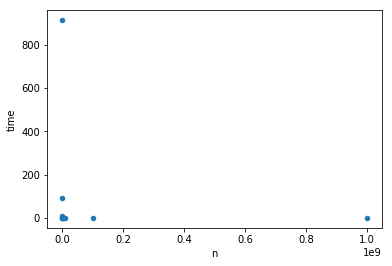

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame({'n':n_list, 'time':avg})
df.sort_values(by = 'time')
df.plot.scatter(x='n', y='time')

**Answer.** To see asymptotically linear behavior, you'll need to try some fairly large values of $n$, e.g., a thousand, ten thousand, a hundred thousand, and a million. Even then, it may **appear** as though the time continues to decrease, but that does not mean you have not reached an asymptote; why not?

> Regarding the latter question, suppose matching time as a function of input size is $t(n) = \alpha + \beta n$, so that the time per match per $n$ is $t(n)/n$.

## A more complex pattern

Consider a regular expression of the form:

$$(a?)^n(a^n) \quad$$

For instance, $n=3$, the regular expression pattern is `(a?){3}a{3} == a?a?a?aaa`. Start by convincing yourself that an input string of the form,

$$a^n = \underbrace{aa\cdots a}_{n \mbox{ occurrences}}$$

should match this pattern. Here is some code to set up an experiment to benchmark this case.

In [11]:
def setup_inputs(n):
    """Sets up the 'complex pattern example' above."""
    s_n = rep_str('a', n)
    p_n = "^(a?){%d}(a{%d})$" % (n, n)
    print ("[n={}] Matching pattern '{}' against input '{}'...".format(n, p_n, s_n))
    assert re.match(p_n, s_n) is not None
    return (p_n, s_n)

n = 3
p_n, s_n = setup_inputs(n)
timing = %timeit -q -o re.match(p_n, s_n)
t_n = sum(timing.all_runs) / len(timing.all_runs) / timing.loops / n * 1e9
print ("==> Time per run per `n`: {} ns".format(t_n))

[n=3] Matching pattern '^(a?){3}(a{3})$' against input 'aaa'...
==> Time per run per `n`: 395.72887461933226 ns


**Exercise 3** (ungraded) Repeat the above experiment but for different values of $n$, such as $n \in \{3, 6, 9, 12, 15, 18\}$. As before, feel free to use the code cell below or make new code cells to contain the code for your experiments. Summarize what you observe. How does the execution time vary with $n$? Can you explain this behavior?

In [13]:
# Use this code cell (and others, if you wish) to set up an experiment
# to test whether matching simple patterns behaves at worst linearly
# in the length of the input.

#
# YOUR CODE HERE
#
n_list = []
avg = []
for i in range(10):
    n = 1*10**i
    n_list.append(n)
    p_n, s_n = setup_inputs(n)
    timing = %timeit -q -o re.match(p_n, s_n)
    t_n = sum(timing.all_runs) / len(timing.all_runs) / timing.loops / n * 1e9
    print('n: {} Time: {}'.format(n, t_n))
    avg.append(t_n)

[n=1] Matching pattern '^(a?){1}(a{1})$' against input 'a'...
n: 1 Time: 932.1170075730022
[n=10] Matching pattern '^(a?){10}(a{10})$' against input 'aaaaaaaaaa'...
n: 10 Time: 5684.83273144271
[n=100] Matching pattern '^(a?){100}(a{100})$' against input 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'...


KeyboardInterrupt: 

**Answer.** Here, you should observe something more like polynomial growth. Here are some results we collected, for instance.

|    n    |  t (ns)    |
|---------|------------|
|       3 | 945.8      |
|       6 | 1611.7     |
|       9 | 7040.1     |
|      12 | 41166.1    |
|      15 | 254927.4   |
|      18 | 1724843.9  |

**Fin!** This cell marks the end of Part 2, which is the final part of this assignment. Don't forget to save, restart and rerun all cells, and submit it.